In [1]:
# standard libraries
import importlib
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import norm
from scipy import linalg, stats, optimize
import time
import sys
sys.path.append('/Users/francescacrucinio/Documents/MD_LVM')

# modules from particles
import particles  # core module
from particles import smc_samplers as ssp
from particles import distributions as dists  # where probability distributions are defined
from particles import resampling as rs


import md_lvm
importlib.reload(md_lvm)

<module 'md_lvm' from '/Users/francescacrucinio/Documents/MD_LVM/md_lvm.py'>

In [110]:
sigma = 1
rho = -0.8
mu = -1.2
T = 100
x = np.zeros(T)
y = np.zeros(T)
x[0] = np.random.normal(loc = mu, scale = sigma/np.sqrt(1-rho**2))
y[0] = np.sqrt(np.exp(x[0]))*np.random.normal(size = 1)
for t in range(1, T):
    x[t] = np.random.normal(loc = mu+rho*(x[t-1]-mu), scale = sigma)
    y[t] = np.sqrt(np.exp(x[t]))*np.random.normal(size = 1)

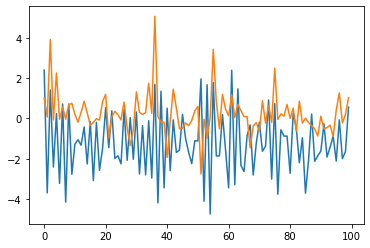

In [111]:
plt.plot(x)
plt.plot(y)

In [143]:
def pgd(y, h, K, N, th0, X):
    """Particle Gradient Ascent Algorithm. Returns parameter estimates."""
    D = y.size  # Extract dimension of latent variables.
    th = np.zeros((K, th0.size))
    th[0, :] = th0
    for k in range(K-1):
        # Update parameter estimate:
        th[k+1, :] = th[k, :] + h*ave_grad_th(th[k, :], X)
        # Update particle cloud:
        X = (X + h*grad_x(thk, X, y)
               + np.sqrt(2*h)*np.random.normal(0, 1, (N, D)))
    return th, X

In [144]:
def ipla(y, h, K, N, th, X):
    """Particle Gradient Ascent Algorithm. Returns parameter estimates."""
    D = y.size  # Extract dimension of latent variables.
    th = np.zeros((K, th0.size))
    th[0, :] = th0
    for k in range(K-1):
        # Update parameter estimate:
        th[k+1, :] = th[k, :] + h*ave_grad_th(th[k, :], X)+ np.sqrt(2*h/N)*np.random.normal(0, 1, size = 2)
        # Update particle cloud:
        X = (X + h*grad_x(thk, X, y)
               + np.sqrt(2*h)*np.random.normal(0, 1, (N, D)))
    return th, X

In [135]:
def ave_grad_th(th, x):
    """Returns theta-gradient of log density averaged over particle cloud."""
    grad_rho = -th[0]/(1-th[0]**2)+th[0]*np.mean((x[:, 0]-th[1])**2)/sigma**2 + np.mean(np.sum((x[:,:(T-1)]-th[1]) * (x[:,1:]-th[1]-th[0]*(x[:,:(T-1)]-th[1])), axis = 1)/sigma**2)
    grad_mu = (1-th[0]**2)*np.mean(x[:, 0]-th[1])/sigma**2 + np.mean(np.sum((1-th[0])*(x[:,1:]-th[1]-th[0]*(x[:,:(T-1)]-th[1])), axis = 1)/sigma**2)
    return np.array(grad_rho)

def grad_x(th, x, y):
    """Returns x-gradient of log density vectorized over particles."""
    grad = y**2*np.exp(-x)/2-1/2
    grad[:, 0] = grad[:, 0] + th[0]*(x[:, 1]-th[1]-th[0]*(x[:,0]-th[1]))/sigma**2-(x[:, 0]-th[1])*(1-th[0]**2)/sigma**2
    grad[:, T-1] = grad[:, T-1] - (x[:, T-1]-th[1]-th[0]*(x[:, T-2]-th[1]))/sigma**2
    grad[:, 1:(T-1)] = grad[:, 1:(T-1)] - (x[:, 1:(T-1)]-th[1]-th[0]*(x[:, 0:(T-2)]-th[1]))/sigma**2 + th[0]*(x[:, 2:T]-th[1]-th[0]*(x[:,1:(T-1)]-th[1]))/sigma**2
    return grad

In [149]:
N = 50
K = 30000
gamma = 0.0001

th0 = np.array([0, 0])  # Initial parameter guess.
X0 = np.random.normal(size = (N, T))  # Initial particle cloud.

In [150]:
th_pgd, X_pgd = pgd(y, gamma, K, N, th0, X0)
th_ipla, X_ipla = ipla(y, gamma, K, N, th0, X0)

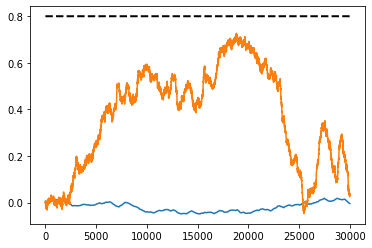

In [151]:
plt.plot(th_pgd[:, 0])
plt.plot(th_ipla[:, 0])
plt.plot(-rho*np.ones(K), c = 'black', linestyle = 'dashed', lw = 2)

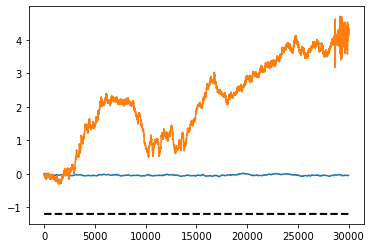

In [148]:
plt.plot(th_pgd[:, 1])
plt.plot(th_ipla[:, 1])
plt.plot(mu*np.ones(K), c = 'black', linestyle = 'dashed', lw = 2)